# Prepare Data

In [4]:
%tensorflow_version

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from shutil import copyfile, rmtree
import zipfile
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import random
import os
import math
from timeit import default_timer as timer
from tqdm import tqdm, trange, tqdm_notebook
from sklearn.preprocessing import LabelBinarizer

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Currently selected TF version: 1.x
Available versions:
* 1.x
* 2.x


In [0]:
dataset_zip_file = 'sign-language-mnist'

In [0]:
with zipfile.ZipFile(f"./{dataset_zip_file}.zip","r") as z:
    z.extractall(f"./{dataset_zip_file}/")

In [7]:
test_df = pd.read_csv(f'./{dataset_zip_file}/sign_mnist_test.csv')
test_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,133,143,148,156,160,162,164,168,171,173,175,178,179,181,182,184,185,185,186,137,116,111,101,110,92,66,108,124,132,155,...,147,132,115,112,117,118,112,153,189,178,173,166,140,121,157,125,93,99,100,101,104,100,118,167,154,141,136,139,135,125,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,176,176,176,178,176,176,178,177,176,178,178,177,176,176,176,174,174,173,173,159,163,164,166,168,169,173,175,177,178,177,...,90,78,191,215,212,214,212,209,209,208,208,207,189,192,196,199,191,208,230,201,197,185,184,187,169,136,131,107,69,127,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,192,193,192,191,192,191,191,192,189,189,189,188,188,188,187,186,185,184,183,193,193,193,193,193,193,194,194,193,195,195,...,215,215,215,214,213,213,212,212,210,209,208,207,215,215,207,207,208,207,203,196,170,99,92,92,89,155,213,216,216,216,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,229,234,233,233,237,237,237,240,241,238,240,240,242,243,241,239,239,239,239,206,209,212,215,218,220,223,226,227,229,236,...,168,173,128,127,255,255,255,255,159,99,80,77,255,255,255,255,255,255,231,255,255,255,255,255,249,231,188,164,169,176,112,169,255,255,237,113,91,67,70,63


In [8]:
train_df = pd.read_csv(f'./{dataset_zip_file}/sign_mnist_train.csv')
train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,194,193,193,194,194,195,195,196,194,195,196,196,197,196,197,197,196,195,195,189,190,192,192,193,194,195,196,196,196,193,...,115,92,132,173,118,84,53,135,253,213,219,208,82,82,84,85,85,87,84,87,78,113,216,189,172,175,155,131,116,93,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,167,169,169,169,169,169,169,169,169,169,167,167,167,166,165,164,164,163,162,153,156,159,160,162,163,164,165,167,169,172,...,199,200,199,199,198,199,198,197,196,195,195,194,66,67,65,62,61,41,32,37,33,30,28,38,187,202,199,199,199,199,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,173,173,172,171,171,171,170,169,168,166,166,165,165,163,162,161,160,158,156,178,178,177,176,177,177,177,176,176,176,175,...,110,85,90,166,205,207,205,203,202,201,200,198,217,217,217,218,218,211,203,200,189,171,157,145,136,129,128,125,101,77,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,190,191,193,192,191,191,191,191,190,190,189,187,186,184,183,182,181,179,177,179,182,185,187,189,190,192,192,192,192,194,...,190,173,140,80,28,60,70,61,61,78,100,86,136,135,135,135,132,132,136,136,137,144,103,120,197,200,195,196,170,149,119,56,27,58,102,79,47,64,87,93


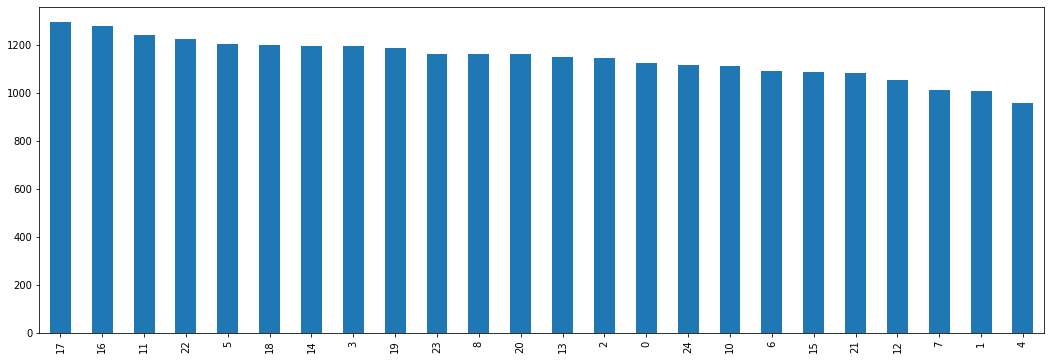

In [9]:
plt.figure(figsize = (18, 6))
train_df['label'].value_counts().plot.bar()

In [10]:
train_df['label'].value_counts()

17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
14    1196
3     1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

In [11]:
max_samples = train_df['label'].value_counts().max()
max_samples

1294

In [0]:
labels = train_df['label'].unique()

In [13]:
img_oversample = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
)

augmented_images = []
for i in labels:
    lack = max_samples - len(train_df[train_df['label'] == i])
    print(i, lack)
    if lack == 0:
        continue
    vals = train_df[train_df['label'] == i].values
    vals = np.delete(vals, 0, axis=1)
    
    to_aug_idx = np.random.choice(len(vals), lack)
    img_to_aug = vals[to_aug_idx]
    
    for img in img_to_aug:
        new_img_iter = img_oversample.flow(img_to_aug[0].reshape(1, 28, 28, 1), y=[i], batch_size=1)
        new_img = new_img_iter.next()[0].reshape(784)
        augmented_images.append(
            pd.Series(np.hstack([i, new_img]), index=train_df.columns)
        )



3 98
6 204
2 150
13 143
16 15
8 132
22 69
18 95
10 180
20 133
17 0
19 108
21 212
23 130
24 176
1 284
12 239
11 53
15 206
4 337
0 168
5 90
7 281
14 98


In [14]:
aug_train_df = train_df.append(augmented_images).astype({'label': 'int32'})
aug_train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107.000000,118.000000,127.000000,134.000000,139.000000,143.000000,146.000000,150.000000,153.000000,156.000000,158.000000,160.000000,163.000000,165.000000,159.000000,166.00000,168.000000,170.000000,170.000000,171.000000,171.000000,171.000000,172.000000,171.000000,171.000000,170.000000,170.000000,169.000000,111.000000,121.000000,129.000000,135.000000,141.000000,144.000000,148.000000,151.000000,154.000000,157.000000,160.000000,...,205.000000,206.000000,206.000000,207.000000,207.000000,206.000000,206.000000,204.000000,205.000000,204.000000,203.000000,202.000000,142.000000,151.000000,160.000000,172.000000,196.000000,188.000000,188.000000,190.000000,135.000000,96.000000,86.000000,77.000000,77.000000,79.000000,176.000000,205.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,206.000000,206.000000,206.000000,204.000000,203.000000,202.000000
1,6,155.000000,157.000000,156.000000,156.000000,156.000000,157.000000,156.000000,158.000000,158.000000,157.000000,158.000000,156.000000,154.000000,154.000000,153.000000,152.00000,151.000000,149.000000,149.000000,148.000000,147.000000,146.000000,144.000000,142.000000,143.000000,138.000000,92.000000,108.000000,158.000000,159.000000,159.000000,159.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,...,100.000000,78.000000,120.000000,157.000000,168.000000,107.000000,99.000000,121.000000,133.000000,97.000000,95.000000,120.000000,135.000000,116.000000,95.000000,79.000000,69.000000,86.000000,139.000000,173.000000,200.000000,185.000000,175.000000,198.000000,124.000000,118.000000,94.000000,140.000000,133.000000,84.000000,69.000000,149.000000,128.000000,87.000000,94.000000,163.000000,175.000000,103.000000,135.000000,149.000000
2,2,187.000000,188.000000,188.000000,187.000000,187.000000,186.000000,187.000000,188.000000,187.000000,186.000000,185.000000,185.000000,185.000000,184.000000,184.000000,184.00000,181.000000,181.000000,179.000000,179.000000,179.000000,178.000000,178.000000,109.000000,52.000000,66.000000,77.000000,83.000000,188.000000,189.000000,189.000000,188.000000,188.000000,189.000000,188.000000,188.000000,188.000000,188.000000,187.000000,...,203.000000,204.000000,203.000000,201.000000,200.000000,200.000000,199.000000,198.000000,196.000000,195.000000,194.000000,193.000000,198.000000,166.000000,132.000000,114.000000,89.000000,74.000000,79.000000,77.000000,74.000000,78.000000,132.000000,188.000000,210.000000,209.000000,206.000000,205.000000,204.000000,203.000000,202.000000,201.000000,200.000000,199.000000,198.000000,199.000000,198.000000,195.000000,194.000000,195.000000
3,2,211.000000,211.000000,212.000000,212.000000,211.000000,210.000000,211.000000,210.000000,210.000000,211.000000,209.000000,207.000000,208.000000,207.000000,206.000000,203.00000,202.000000,201.000000,200.000000,198.000000,197.000000,195.000000,192.000000,197.000000,171.000000,51.000000,52.000000,54.000000,212.000000,213.000000,215.000000,215.000000,212.000000,212.000000,213.000000,212.000000,212.000000,211.000000,211.000000,...,247.000000,242.000000,233.000000,231.000000,230.000000,229.000000,227.000000,225.000000,223.000000,221.000000,220.000000,216.000000,58.000000,51.000000,49.000000,50.000000,57.000000,60.000000,17.000000,15.000000,18.000000,17.000000,19.000000,1.000000,159.000000,255.000000,237.000000,239.000000

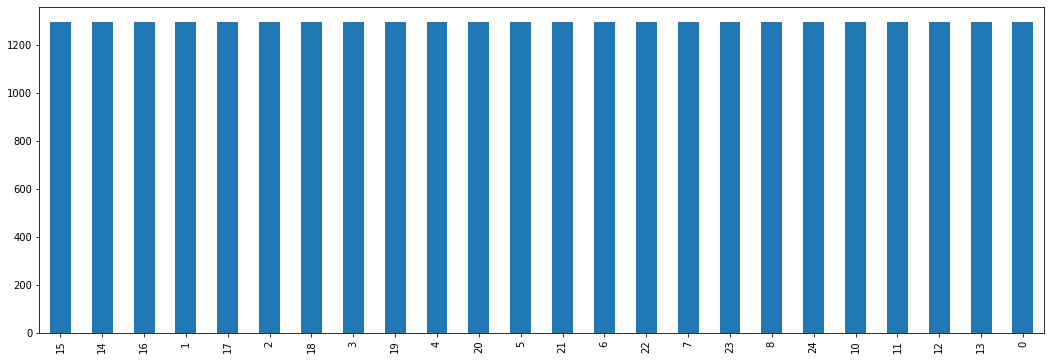

In [15]:
plt.figure(figsize = (18, 6))
aug_train_df['label'].value_counts().plot.bar()

In [0]:
aug_train_df, aug_valid_df = train_test_split(aug_train_df, test_size=0.25, random_state=42, stratify=aug_train_df['label'])

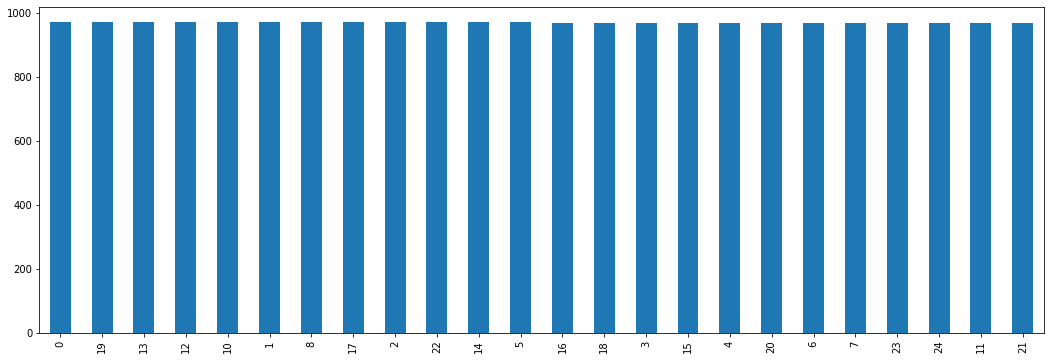

In [17]:
plt.figure(figsize = (18, 6))
aug_train_df['label'].value_counts().plot.bar()

In [18]:
aug_valid_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
25614,1,183.000000,183.000000,185.000000,185.000000,187.000000,186.000000,185.000000,185.000000,185.000000,184.000000,183.000000,182.000000,181.000000,181.000000,180.000000,178.000000,178.000000,176.00000,174.000000,174.000000,173.000000,173.000000,172.000000,168.0,174.000000,76.000000,47.000000,48.000000,184.000000,185.000000,187.000000,187.000000,188.000000,187.000000,187.000000,187.000000,186.000000,185.000000,185.000000,...,105.000000,77.000000,52.000000,161.000000,212.000000,183.000000,139.000000,86.000000,55.000000,43.000000,46.000000,56.000000,208.000000,210.000000,211.000000,210.000000,221.000000,133.000000,63.000000,72.000000,62.000000,59.000000,75.000000,114.000000,119.000000,106.000000,99.000000,110.000000,88.000000,53.000000,134.000000,211.000000,151.000000,83.000000,48.000000,41.000000,42.000000,44.000000,47.000000,50.000000
23125,11,117.000000,119.000000,123.000000,124.000000,125.000000,128.000000,130.000000,131.000000,132.000000,134.000000,137.000000,137.000000,136.000000,137.000000,137.000000,138.000000,139.000000,139.00000,138.000000,138.000000,138.000000,139.000000,140.000000,140.0,139.000000,139.000000,138.000000,138.000000,118.000000,120.000000,124.000000,124.000000,125.000000,128.000000,131.000000,131.000000,132.000000,134.000000,136.000000,...,163.000000,162.000000,163.000000,163.000000,161.000000,160.000000,160.000000,159.000000,159.000000,159.000000,158.000000,157.000000,165.000000,133.000000,127.000000,141.000000,115.000000,110.000000,103.000000,98.000000,85.000000,62.000000,48.000000,141.000000,165.000000,159.000000,160.000000,162.000000,163.000000,163.000000,162.000000,163.000000,162.000000,160.000000,161.000000,160.000000,159.000000,159.000000,159.000000,159.000000
18430,15,96.000000,97.000000,99.000000,100.000000,104.000000,114.000000,124.000000,136.000000,143.000000,152.000000,157.000000,161.000000,161.000000,166.000000,170.000000,175.000000,180.000000,183.00000,187.000000,189.000000,191.000000,194.000000,197.000000,198.0,201.000000,203.000000,205.000000,206.000000,95.000000,97.000000,101.000000,101.000000,104.000000,115.000000,125.000000,136.000000,144.000000,152.000000,159.000000,...,131.000000,131.000000,129.000000,129.000000,216.000000,193.000000,174.000000,166.000000,154.000000,137.000000,120.000000,111.000000,130.000000,130.000000,130.000000,130.000000,130.000000,131.000000,131.000000,131.000000,131.000000,130.000000,131.000000,133.000000,133.000000,134.000000,134.000000,132.000000,134.000000,134.000000,135.000000,124.000000,191.000000,210.000000,196.000000,189.000000,173.000000,138.000000,109.000000,110.000000
3127,1,122.000000,125.000000,129.000000,132.000000,136.000000,138.000000,138.000000,139.000000,139.000000,140.000000,141.000000,143.000000,142.000000,144.000000,148.000000,146.000000,147.000000,140.00000,146.000000,146.000000,145.000000,145.000000,145.000000,145.0,144.000000,143.000000,145.000000,145.000000,126.000000,129.000000,133.000000,136.000000,139.000000,142.000000,141.000000,144.000000,144.000000,145.000000,146.000000,...,66.000000,117.000000,225.000000,217.000000,217.000000,217.000000,217.000000,219.000000,218.000000,218.000000,216.000000,216.000000,191.000000,195.000000,200.000000,205.000000,206.000000,207.000000,199.000000,207.000000,201.000000,190.000000,187.000000,155.000000,137.000000,122.000000,111.000000,80.

In [0]:
label_binrizer = LabelBinarizer()

def df_to_x_y(df):
    
    y = label_binrizer.fit_transform(np.array(df['label']))
    
    x_df = df.drop('label', axis = 1)
    x = np.array(x_df).reshape(-1, 28, 28, 1)
    
    return x, y

In [20]:
train_x, train_y = df_to_x_y(aug_train_df)
train_x.shape, train_y.shape

((23292, 28, 28, 1), (23292, 24))

In [21]:
valid_x, valid_y = df_to_x_y(aug_valid_df)
valid_x.shape, valid_y.shape

((7764, 28, 28, 1), (7764, 24))

In [22]:
test_x, test_y = df_to_x_y(test_df)
test_x.shape, test_y.shape

((7172, 28, 28, 1), (7172, 24))

# Train Models

In [0]:
def plot_curves(title, data, y_title, x_title='Epoch', legend=[], x_labels_offset = 0):
    fig = plt.figure(figsize=(8, 4))
        
    for row in data:
        x = range(x_labels_offset, len(row))
        plt.plot(x, row[x_labels_offset:])
    
    plt.title(title)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.grid(True)
    plt.legend(legend, loc='upper left')
    plt.show()

In [0]:
WIDTH = 28
HEIGHT = 28
IMG_SIZE = (WIDTH, HEIGHT)
CHANNELS = 1
OUTPUT = 24

In [0]:
class BaseModel():
    def __init__(self, drop_out=0.15):
        self.init_basic_params(drop_out)
        
        self.compile()
        
        self.tf_writer.add_graph(self.session.graph)
    
    def rand_str(self, str_len=20):
        return ''.join(random.choices(string.ascii_uppercase + string.digits, k=str_len))
    
    def init_basic_params(self, drop_out):
        tf.reset_default_graph()
        self.logs_path = './tf_board/' + self.__class__.__name__
        self.var_scope = self.rand_str()
        self.print_separator = '-' * 65
        self.session = None
        self.dropout_rate_tf = tf.placeholder(tf.float32)
        self.dropout_rate_tf_cnn = tf.placeholder(tf.float32)
        
        self.input_size = [WIDTH, HEIGHT, CHANNELS]
        self.output_size = OUTPUT
        
        self.dropout_rate = drop_out
        self.dropout_rate_cnn = 0.0
        
        self.start_learning_rate = 0.01
        
        self.tf_writer = tf.summary.FileWriter(self.logs_path)
    
    def __del__(self): 
        print('object del')
        if self.session:
            tf.reset_default_graph()
            self.session.close()
    
    def reset_internal_params(self):
        self.hidden_layers = {}
        self.hidden_layers_W = {}
        self.hidden_layers_b = {}
        self.history = {
            'acc_train': [],
            'acc_valid': [],
            'loss_train': [],
            'loss_valid': []
        }
        
        self.global_step = tf.Variable(0, trainable=False)
        self.decay_steps = tf.Variable(100000, trainable=False)
    
    def get_W(self, layer_id, shape):
        #with tf.variable_scope(self.var_scope, reuse=tf.AUTO_REUSE):
        #W = tf.Variable(tf.truncated_normal(shape, stddev=0.1, mean=0), name=f'W_{layer_id}')
        initializer = tf.contrib.layers.variance_scaling_initializer()
        W = tf.Variable(initializer(shape), name=f'W_{layer_id}')
        self.hidden_layers_W[layer_id] = W

        return self.hidden_layers_W[layer_id]

    def get_b(self, layer_id, shape):
        #with tf.variable_scope(self.var_scope, reuse=tf.AUTO_REUSE):
        self.hidden_layers_b[layer_id] = tf.Variable(tf.zeros(shape), name=f'b_{layer_id}')
        
        return self.hidden_layers_b[layer_id]
        
    def get_dense_layer(self, layer_id, prev_layer, units_count, activ=tf.nn.relu):
        input_size = prev_layer.get_shape().as_list()[1]
        
        W = self.get_W(layer_id, [input_size, units_count])
        b = self.get_b(layer_id, [units_count])
        
        layer = tf.matmul(prev_layer, W) + b
        
        if activ:
            layer = activ(layer, name=f'Lay_Dense_{layer_id}')
        
        return layer
    
    def get_conv2_layer(self, layer_id, prev_layer, kernel_size, output_channels, strides=1, padding='SAME', activ=tf.nn.relu):
        input_channels = prev_layer.get_shape().as_list()[3]
        
        # 5x5 conv, 1 input, 32 outputs
        # [filter_height, filter_width, in_channels, out_channels]
        filter_shape = [kernel_size[0], kernel_size[1], input_channels, output_channels]

        W = self.get_W(layer_id, filter_shape)
        b = self.get_b(layer_id, [output_channels])
        
        layer = tf.nn.conv2d(prev_layer, W, [1, strides, strides, 1], padding) + b
        
        if activ:
            layer = activ(layer, name=f'Lay_Conv2d_{layer_id}')  
        
        return layer
    
    def flatten(self, input):
        shape = input.get_shape().as_list()
        shape = np.array(shape)
        size = shape[shape != None].prod()
        
        return tf.reshape(input, [-1, size], name='Flatten')
    
    def batch_norm(self, input):
        #return tf.contrib.layers.batch_norm(input, fused=True, data_format='NCHW')
        return tf.contrib.layers.batch_norm(input)
    
    def get_max_pooling(self, layer_id, input, ksize, stride=1, padding='SAME'):
        return tf.nn.max_pool(input, [1, ksize, ksize, 1], [1, stride, stride, 1], padding, name=f'max_pool_{layer_id}')

    def get_avg_pooling(self, layer_id, input, ksize, stride=1, padding='SAME'):
        return tf.nn.avg_pool(input, [1, ksize, ksize, 1], [1, stride, stride, 1], padding, name=f'avg_pool_{layer_id}')
    
    def pre_compile():
        print('precompile')
    
    def next_batch(self, x, y, batch_size, iteration):
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        
        return x[start:end], y[start:end]
    
    def l2_reg(self, loss_rate=0.01):
        reg_sum = 0
        for key in self.hidden_layers_W:
            reg_sum += tf.nn.l2_loss(self.hidden_layers_W[key])
        
        return loss_rate * reg_sum
    
    def compile(self):
        
        self.lr = tf.placeholder(tf.float32, shape=[])
        
        self.pre_compile()
        
        self.prediction_proba = tf.nn.softmax(self.layer_output, name='Output')
        self.prediction = tf.round(self.prediction_proba)
        
        #self.accuracy = tf.reduce_mean(
        #    tf.cast(
        #        tf.equal(tf.argmax(self.prediction, 1), tf.argmax(self.expected_output, 1)),
        #        tf.float32,
        #    ),
        #    name='Accuracy'
        #)
        
        self.accuracy = tf.reduce_mean(
            tf.cast(
                tf.equal(tf.argmax(self.prediction, 1), tf.argmax(self.expected_output, 1)),
                tf.float32
            ),
            name='Accuracy'
        )
                
        self.session = tf.Session()
        self.vars = tf.global_variables_initializer()
        self.session.run(tf.global_variables_initializer())
    
    def fit_gen(self, train_gen, valid_gen=None, epochs=1):
        
        fit_start = timer()
        
        iterations = train_gen.__len__()
        batch_size = train_gen.batch_size
            
        print(self.print_separator)
        print(f'Epochs: {epochs}\t| Iterations: {iterations}\t| Batch: {batch_size}')
        print(self.print_separator)
        
        for epoch in range(epochs):
            
            start = timer()
            loss_train = 0
            acc_train = 0
            
            with trange(iterations) as t:
                for iteration in t:
                    x_batch, y_batch = train_gen.__getitem__(iteration)
                    
                    #loss_container = []
                    #acc_container = []
                    
                    feed_data = { 
                        self.input: x_batch, 
                        self.expected_output: y_batch.reshape([-1, self.output_size]),
                        self.dropout_rate_tf: self.dropout_rate,
                        self.dropout_rate_tf_cnn: self.dropout_rate_cnn
                    }

                    self.session.run(self.optimizer, feed_dict=feed_data)


                    feed_data_metrics = { 
                        self.input: x_batch, 
                        self.expected_output: y_batch.reshape([-1, self.output_size]),
                        self.dropout_rate_tf: 0,
                        self.dropout_rate_tf_cnn: 0
                    }

                    loss, acc = self.session.run([self.loss, self.accuracy], feed_dict=feed_data_metrics)

                    #loss_container.append(loss)
                    #acc_container.append(acc)
                    
                    loss_train += loss / iterations
                    acc_train += acc / iterations
                    #loss_train = np.mean(loss_container)
                    #acc_train = np.mean(acc_container)
                    
                    t.set_description(f'Epoch: {epoch + 1}')

                    t.set_postfix(loss=f'{loss_train:.5f}', acc=f'{acc_train:.02%}')

                    #if iteration % 20 == 0 and iteration > 0:
                    #    print(f'iteration: {iteration}')
                

            #loss_train, acc_train = self.evaluate_gen(train_gen)
        
            self.history['loss_train'].append(loss_train)            
            self.history['acc_train'].append(acc_train)
            
            
            if valid_gen != None:
                loss_valid, acc_valid = self.evaluate_gen(valid_gen)
        
                self.history['loss_valid'].append(loss_valid)
                self.history['acc_valid'].append(acc_valid)
            
            end = timer()
            
            epoch_time = end - start
            
            if valid_gen != None:
                print(f'Epoch {epoch + 1}: ({epoch_time:.5f} s) \t loss - Tr[{loss_train:.5f}] Va[{loss_valid:.5f}] \t acc - Tr[{acc_train:.02%}] Va[{acc_valid:.02%}]')
            else:
                print(f'Epoch {epoch + 1}: ({epoch_time:.5f} s) \t loss - Tr[{loss_train:.5f}] \t acc - Tr[{acc_train:.02%}]')
                
            print(self.print_separator)
        
        fit_end = timer()
        
        epoch_time = fit_end - fit_start
        print(f'Finished in: {epoch_time:.4f} s')
        
    def evaluate_gen(self, eval_gen):
        loss = 0
        acc = 0

        iterations = eval_gen.__len__()
        
        for iteration in range(iterations):
            x_batch, y_batch = eval_gen.__getitem__(iteration)
            feed_data = { 
                    self.input: x_batch, 
                    self.expected_output: y_batch.reshape([-1, self.output_size]),
                    self.dropout_rate_tf: 0,
                    self.dropout_rate_tf_cnn: 0
                }
                
            batch_loss, batch_acc = self.session.run([self.loss, self.accuracy], feed_dict=feed_data)
            
            acc += batch_acc / iterations
            loss += batch_loss / iterations
                
        return loss, acc 
    
    def evaluate(self, x=None, y=None):
        feed_data = { self.input: x, self.expected_output: y, self.dropout_rate_tf: 0, self.dropout_rate_tf_cnn: 0}
        return self.session.run([self.loss, self.accuracy], feed_dict=feed_data)
    
    def predict(self, x, batch_size=None):
        if batch_size is None:
            feed_data = { self.input: x, self.dropout_rate_tf: 0}
            return self.session.run(self.prediction, feed_dict=feed_data)
        
        

    def predict_proba(self, x, batch_size=None):
        if batch_size is None:
            feed_data = { self.input: x, self.dropout_rate_tf: 0, self.dropout_rate_tf_cnn: 0}
            return self.session.run(self.prediction_proba, feed_dict=feed_data)
        
        output = []
        
        iterations = math.ceil(len(x) / batch_size)
        for iteration in range(iterations):
            x_batch, _ = self.next_batch(x, x, batch_size, iteration)
            feed_data = { self.input: x_batch, self.dropout_rate_tf: 0, self.dropout_rate_tf_cnn: 0}
            result = self.session.run(self.prediction_proba, feed_dict=feed_data)
            output.append(result)
        
        return np.vstack(output)
    

In [0]:
class Model1(BaseModel):
    def __init__(self, drop_out=0.15):
        BaseModel.__init__(self, drop_out)

    def init_basic_params(self, drop_out):
        super().init_basic_params(drop_out)
        
        self.start_learning_rate = 0.001
        
    def pre_compile(self):
        self.reset_internal_params()

        self.input = tf.placeholder(tf.float32, shape=[None, *self.input_size], name="Input")
        self.expected_output = tf.placeholder(tf.float32, shape=[None, self.output_size], name="Y_actual")
   
        out = self.get_conv2_layer(1, self.input, [4, 4], 32)
        out = self.batch_norm(out)
        out = self.get_max_pooling(2, out, 2, stride=2)
        out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
    
        out = self.get_conv2_layer(3, out, [4, 4], 64)
        out = self.batch_norm(out)
        out = self.get_max_pooling(4, out, 2, stride=2)
        out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
        
        
        out = self.get_conv2_layer(7, out, [4, 4], 128)
        out = self.batch_norm(out)
        out = self.get_max_pooling(8, out, 2, stride=2)
        
        #out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
        
        #out = self.get_conv2_layer(9, out, [1, 1], 256)
        
        #out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
        #out = self.get_conv2_layer(7, out, [5, 5], 256)
        #out = self.batch_norm(out)
        #out = self.get_max_pooling(8, out, 2, stride=2)
        
        #out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
        #out = self.get_conv2_layer(9, out, [1, 1], 512)

        out = self.flatten(out)
        
        #out = tf.nn.dropout(out, rate=self.dropout_rate_tf)

        out = self.get_dense_layer(10, out, 128)
        
        out = tf.nn.dropout(out, rate=self.dropout_rate_tf)

        out = self.get_dense_layer(11, out, 128)
        
        out = tf.nn.dropout(out, rate=self.dropout_rate_tf)
        
        out = self.get_dense_layer(12, out, self.output_size, activ=None)

        self.layer_output = out
        
        self.loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.expected_output, logits=self.layer_output),
            name='Loss'
        ) #+ self.l2_reg(loss_rate=0.001)
        
        #self.optimizer = tf.train.RMSPropOptimizer(self.start_learning_rate).minimize(self.loss, global_step=self.global_step)
        self.optimizer = tf.train.AdamOptimizer(self.start_learning_rate).minimize(self.loss, global_step=self.global_step)

In [0]:
BATCH_SIZE=64
VALID_BATCH_SIZE=64
EPOCH=30
TR_LAERN_EPOCH = 20

In [0]:
o_data_gen = ImageDataGenerator(rescale=1.0/255.0)

o_train_gen = o_data_gen.flow(x=train_x, y=train_y, batch_size=BATCH_SIZE, shuffle=True)
o_valid_gen = o_data_gen.flow(x=valid_x, y=valid_y, batch_size=VALID_BATCH_SIZE, shuffle=True)
o_test_gen = o_data_gen.flow(x=test_x, y=test_y, batch_size=VALID_BATCH_SIZE, shuffle=True)


In [0]:
def print_test(title, model):
    orig_test_loss, orig_test_acc = model.evaluate_gen(o_test_gen)

    print(f'{title}: loss - {orig_test_loss:.4f}\t Acc - {orig_test_acc:.02%}')

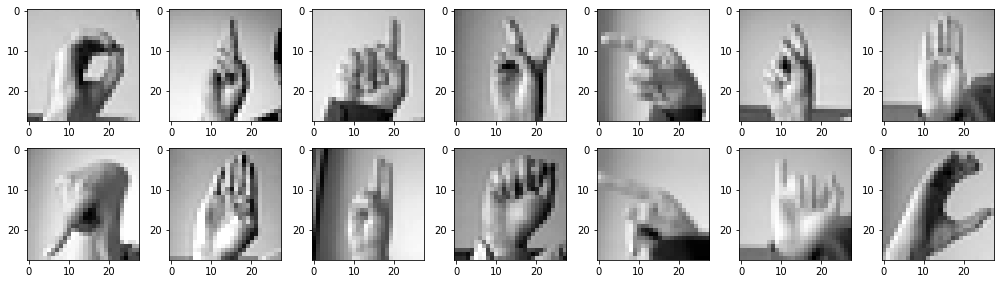

In [30]:
plt.figure(figsize=(14, 4))
for i in range(0, 14):
    plt.subplot(2, 7, i+1)
    for X_batch, Y_batch in o_train_gen:
        image = X_batch[0]
        plt.imshow(image.reshape(28, 28), cmap='gray')
        break
plt.tight_layout()
plt.show()

In [45]:
orig_model_1 = Model1(drop_out=0.42)
orig_model_1.fit_gen(o_train_gen, o_valid_gen, epochs=EPOCH)

Epoch: 1:   0%|          | 1/364 [00:00<01:06,  5.45it/s, acc=0.00%, loss=0.00874]

object del
-----------------------------------------------------------------
Epochs: 30	| Iterations: 364	| Batch: 64
-----------------------------------------------------------------


Epoch: 2:   2%|▏         | 9/364 [00:00<00:04, 83.14it/s, acc=2.17%, loss=0.04113]

Epoch 1: (5.02841 s) 	 loss - Tr[2.01321] Va[0.93845] 	 acc - Tr[23.78%] Va[57.20%]
-----------------------------------------------------------------


Epoch: 3:   2%|▏         | 9/364 [00:00<00:04, 81.74it/s, acc=3.29%, loss=0.02257]

Epoch 2: (4.80183 s) 	 loss - Tr[0.69342] Va[0.49667] 	 acc - Tr[67.79%] Va[76.76%]
-----------------------------------------------------------------


Epoch: 4:   2%|▏         | 9/364 [00:00<00:04, 84.67it/s, acc=4.33%, loss=0.00757]

Epoch 3: (4.69294 s) 	 loss - Tr[0.31477] Va[0.20808] 	 acc - Tr[85.25%] Va[89.94%]
-----------------------------------------------------------------


Epoch: 5:   2%|▏         | 8/364 [00:00<00:04, 75.59it/s, acc=3.94%, loss=0.00307]

Epoch 4: (4.72158 s) 	 loss - Tr[0.11437] Va[0.07387] 	 acc - Tr[94.50%] Va[95.34%]
-----------------------------------------------------------------


Epoch: 6:   2%|▏         | 8/364 [00:00<00:04, 79.45it/s, acc=4.10%, loss=0.00195]

Epoch 5: (4.83052 s) 	 loss - Tr[0.06612] Va[0.04569] 	 acc - Tr[97.60%] Va[99.32%]
-----------------------------------------------------------------


Epoch: 7:   2%|▏         | 8/364 [00:00<00:04, 78.89it/s, acc=4.38%, loss=0.00176]

Epoch 6: (4.78987 s) 	 loss - Tr[0.04734] Va[0.05026] 	 acc - Tr[99.30%] Va[99.08%]
-----------------------------------------------------------------


Epoch: 8:   2%|▏         | 9/364 [00:00<00:04, 85.84it/s, acc=4.39%, loss=0.00098]

Epoch 7: (4.71722 s) 	 loss - Tr[0.03483] Va[0.02529] 	 acc - Tr[99.63%] Va[99.71%]
-----------------------------------------------------------------


Epoch: 9:   2%|▏         | 8/364 [00:00<00:04, 78.07it/s, acc=4.38%, loss=0.00078]

Epoch 8: (4.67224 s) 	 loss - Tr[0.01731] Va[0.01646] 	 acc - Tr[99.86%] Va[99.87%]
-----------------------------------------------------------------


Epoch: 10:   2%|▏         | 9/364 [00:00<00:04, 78.43it/s, acc=4.12%, loss=0.00057]

Epoch 9: (4.67179 s) 	 loss - Tr[0.01638] Va[0.01892] 	 acc - Tr[99.87%] Va[99.68%]
-----------------------------------------------------------------


Epoch: 11:   2%|▏         | 8/364 [00:00<00:04, 77.08it/s, acc=4.12%, loss=0.00046]

Epoch 10: (4.62228 s) 	 loss - Tr[0.01457] Va[0.01794] 	 acc - Tr[99.94%] Va[99.82%]
-----------------------------------------------------------------


Epoch: 12:   2%|▏         | 8/364 [00:00<00:04, 79.98it/s, acc=4.39%, loss=0.00046]

Epoch 11: (4.88333 s) 	 loss - Tr[0.01406] Va[0.01511] 	 acc - Tr[99.90%] Va[99.75%]
-----------------------------------------------------------------


Epoch: 13:   2%|▏         | 8/364 [00:00<00:04, 76.56it/s, acc=4.12%, loss=0.00025]

Epoch 12: (4.82777 s) 	 loss - Tr[0.01101] Va[0.01425] 	 acc - Tr[99.92%] Va[99.81%]
-----------------------------------------------------------------


Epoch: 14:   2%|▏         | 9/364 [00:00<00:04, 87.73it/s, acc=4.40%, loss=0.00026]

Epoch 13: (4.78596 s) 	 loss - Tr[0.01031] Va[0.00889] 	 acc - Tr[99.94%] Va[99.91%]
-----------------------------------------------------------------


Epoch: 15:   2%|▏         | 8/364 [00:00<00:04, 76.74it/s, acc=4.12%, loss=0.00044]

Epoch 14: (4.66063 s) 	 loss - Tr[0.00877] Va[0.01589] 	 acc - Tr[99.90%] Va[99.91%]
-----------------------------------------------------------------


Epoch: 16:   2%|▏         | 8/364 [00:00<00:04, 79.02it/s, acc=4.38%, loss=0.00040]

Epoch 15: (4.76189 s) 	 loss - Tr[0.00732] Va[0.00916] 	 acc - Tr[99.92%] Va[99.80%]
-----------------------------------------------------------------


Epoch: 17:   2%|▏         | 8/364 [00:00<00:04, 79.58it/s, acc=4.40%, loss=0.00010]

Epoch 16: (4.67093 s) 	 loss - Tr[0.00652] Va[0.00437] 	 acc - Tr[99.86%] Va[99.90%]
-----------------------------------------------------------------


Epoch: 18:   2%|▏         | 8/364 [00:00<00:04, 77.50it/s, acc=4.12%, loss=0.00042]

Epoch 17: (4.73339 s) 	 loss - Tr[0.00734] Va[0.02223] 	 acc - Tr[99.91%] Va[99.43%]
-----------------------------------------------------------------


Epoch: 19:   2%|▏         | 8/364 [00:00<00:04, 77.69it/s, acc=4.40%, loss=0.00007]

Epoch 18: (4.84236 s) 	 loss - Tr[0.01036] Va[0.01723] 	 acc - Tr[99.89%] Va[99.70%]
-----------------------------------------------------------------


Epoch: 20:   2%|▏         | 9/364 [00:00<00:04, 85.60it/s, acc=4.67%, loss=0.00008]

Epoch 19: (4.69104 s) 	 loss - Tr[0.00603] Va[0.00372] 	 acc - Tr[99.94%] Va[99.92%]
-----------------------------------------------------------------


Epoch: 21:   2%|▏         | 8/364 [00:00<00:04, 77.63it/s, acc=4.11%, loss=0.00028]

Epoch 20: (4.70310 s) 	 loss - Tr[0.00458] Va[0.00961] 	 acc - Tr[99.94%] Va[99.75%]
-----------------------------------------------------------------


Epoch: 22:   2%|▏         | 9/364 [00:00<00:04, 83.73it/s, acc=4.40%, loss=0.00007]

Epoch 21: (4.67210 s) 	 loss - Tr[0.00563] Va[0.00298] 	 acc - Tr[99.95%] Va[99.97%]
-----------------------------------------------------------------


Epoch: 23:   2%|▏         | 8/364 [00:00<00:04, 78.40it/s, acc=4.39%, loss=0.00020]

Epoch 22: (4.66480 s) 	 loss - Tr[0.00436] Va[0.00390] 	 acc - Tr[99.93%] Va[99.95%]
-----------------------------------------------------------------


Epoch: 24:   2%|▏         | 8/364 [00:00<00:04, 79.56it/s, acc=4.40%, loss=0.00009]

Epoch 23: (4.70960 s) 	 loss - Tr[0.00660] Va[0.00209] 	 acc - Tr[99.88%] Va[99.95%]
-----------------------------------------------------------------


Epoch: 25:   2%|▏         | 8/364 [00:00<00:04, 77.02it/s, acc=4.39%, loss=0.00019]

Epoch 24: (4.75922 s) 	 loss - Tr[0.00869] Va[0.00874] 	 acc - Tr[99.71%] Va[99.79%]
-----------------------------------------------------------------


Epoch: 26:   2%|▏         | 8/364 [00:00<00:04, 77.70it/s, acc=4.39%, loss=0.00023]

Epoch 25: (4.79792 s) 	 loss - Tr[0.00665] Va[0.00905] 	 acc - Tr[99.74%] Va[99.76%]
-----------------------------------------------------------------


Epoch: 27:   2%|▏         | 9/364 [00:00<00:04, 87.13it/s, acc=4.67%, loss=0.00007]

Epoch 26: (4.64345 s) 	 loss - Tr[0.00460] Va[0.00457] 	 acc - Tr[99.87%] Va[99.87%]
-----------------------------------------------------------------


Epoch: 28:   2%|▏         | 8/364 [00:00<00:04, 78.20it/s, acc=4.40%, loss=0.00010]

Epoch 27: (4.66605 s) 	 loss - Tr[0.00473] Va[0.00180] 	 acc - Tr[99.90%] Va[99.96%]
-----------------------------------------------------------------


Epoch: 29:   2%|▏         | 9/364 [00:00<00:04, 87.97it/s, acc=4.67%, loss=0.00012]

Epoch 28: (4.66286 s) 	 loss - Tr[0.00409] Va[0.00208] 	 acc - Tr[99.86%] Va[99.97%]
-----------------------------------------------------------------


Epoch: 30:   2%|▏         | 8/364 [00:00<00:04, 78.24it/s, acc=4.12%, loss=0.00005]

Epoch 29: (4.67200 s) 	 loss - Tr[0.00500] Va[0.00277] 	 acc - Tr[99.91%] Va[99.91%]
-----------------------------------------------------------------


Epoch: 30: 100%|██████████| 364/364 [00:04<00:00, 79.93it/s, acc=99.91%, loss=0.00395]


Epoch 30: (4.83351 s) 	 loss - Tr[0.00395] Va[0.00192] 	 acc - Tr[99.91%] Va[99.97%]
-----------------------------------------------------------------
Finished in: 142.2012 s


In [47]:
print_test('Original model', orig_model_1)

Original model: loss - 0.1423	 Acc - 98.72%


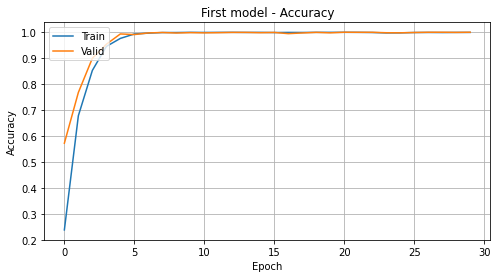

In [48]:
plot_curves(f'First model - Accuracy', [orig_model_1.history['acc_train'], orig_model_1.history['acc_valid']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


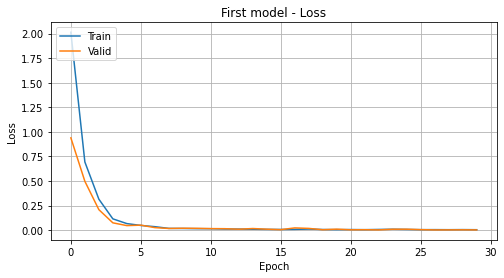

In [49]:
plot_curves(f'First model - Loss', [orig_model_1.history['loss_train'], orig_model_1.history['loss_valid']], 'Loss', 'Epoch', ['Train', 'Valid'])


# dat augmentation

In [0]:
aug_data_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

aug_train_gen = aug_data_gen.flow(x=train_x, y=train_y, batch_size=BATCH_SIZE, shuffle=True)


object del


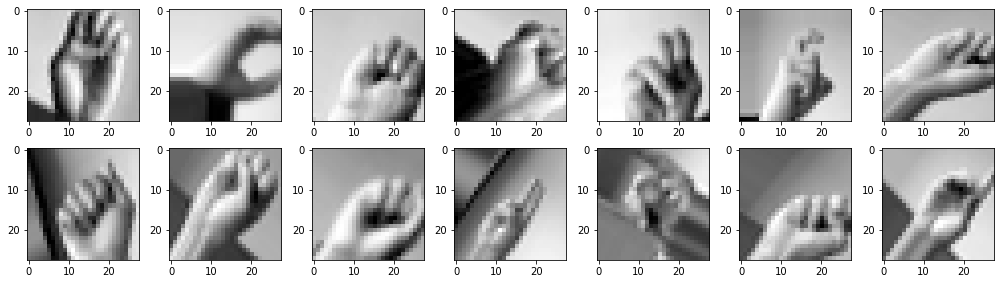

In [51]:
plt.figure(figsize=(14, 4))
for i in range(0, 14):
    plt.subplot(2, 7, i+1)
    X_batch, Y_batch = aug_train_gen.__getitem__(i)
    image = X_batch[0]
    plt.imshow(image.reshape(28,28), cmap='gray')
    
plt.tight_layout()
plt.show()

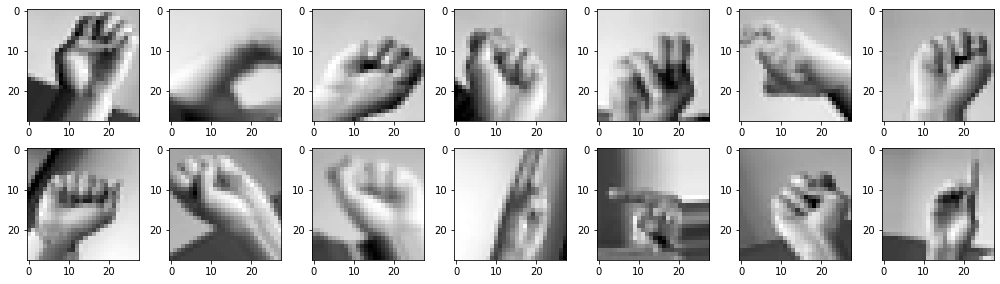

In [52]:
plt.figure(figsize=(14, 4))
for i in range(0, 14):
    plt.subplot(2, 7, i+1)
    X_batch, Y_batch = aug_train_gen.__getitem__(i)
    image = X_batch[0]
    plt.imshow(image.reshape(28,28), cmap='gray')
    
plt.tight_layout()
plt.show()

In [59]:
aug_model_1 = Model1(drop_out=0.2)
aug_model_1.fit_gen(aug_train_gen, o_valid_gen, epochs=EPOCH)

Epoch: 1:   0%|          | 1/364 [00:00<01:11,  5.10it/s, acc=0.01%, loss=0.00907]

-----------------------------------------------------------------
Epochs: 30	| Iterations: 364	| Batch: 64
-----------------------------------------------------------------


Epoch: 2:   1%|          | 4/364 [00:00<00:10, 35.12it/s, acc=0.16%, loss=0.05431]

Epoch 1: (10.05213 s) 	 loss - Tr[3.06713] Va[2.74202] 	 acc - Tr[4.92%] Va[8.02%]
-----------------------------------------------------------------


Epoch: 3:   1%|▏         | 5/364 [00:00<00:08, 41.27it/s, acc=0.21%, loss=0.04790]

Epoch 2: (10.09299 s) 	 loss - Tr[2.69943] Va[2.39016] 	 acc - Tr[8.12%] Va[13.30%]
-----------------------------------------------------------------


Epoch: 4:   1%|          | 4/364 [00:00<00:11, 32.19it/s, acc=0.28%, loss=0.03536]

Epoch 3: (9.83611 s) 	 loss - Tr[2.27011] Va[1.89580] 	 acc - Tr[14.72%] Va[23.39%]
-----------------------------------------------------------------


Epoch: 5:   1%|          | 4/364 [00:00<00:09, 39.36it/s, acc=0.59%, loss=0.02809]

Epoch 4: (9.85135 s) 	 loss - Tr[1.78192] Va[1.20157] 	 acc - Tr[22.69%] Va[39.50%]
-----------------------------------------------------------------


Epoch: 6:   1%|          | 4/364 [00:00<00:09, 39.40it/s, acc=0.82%, loss=0.02243]

Epoch 5: (9.74931 s) 	 loss - Tr[1.35279] Va[0.99005] 	 acc - Tr[33.42%] Va[49.85%]
-----------------------------------------------------------------


Epoch: 7:   1%|          | 4/364 [00:00<00:09, 37.54it/s, acc=0.98%, loss=0.01811]

Epoch 6: (9.88766 s) 	 loss - Tr[1.07842] Va[0.70964] 	 acc - Tr[44.59%] Va[63.01%]
-----------------------------------------------------------------


Epoch: 8:   1%|          | 4/364 [00:00<00:09, 38.35it/s, acc=1.18%, loss=0.01558]

Epoch 7: (10.02964 s) 	 loss - Tr[0.87134] Va[0.60397] 	 acc - Tr[55.44%] Va[68.58%]
-----------------------------------------------------------------


Epoch: 9:   1%|▏         | 5/364 [00:00<00:08, 40.37it/s, acc=1.24%, loss=0.01370]

Epoch 8: (9.98453 s) 	 loss - Tr[0.72907] Va[0.47729] 	 acc - Tr[62.76%] Va[76.27%]
-----------------------------------------------------------------


Epoch: 10:   1%|          | 4/364 [00:00<00:10, 34.58it/s, acc=1.42%, loss=0.01037]

Epoch 9: (9.92077 s) 	 loss - Tr[0.60849] Va[0.33986] 	 acc - Tr[70.01%] Va[85.49%]
-----------------------------------------------------------------


Epoch: 11:   1%|          | 4/364 [00:00<00:09, 39.79it/s, acc=1.56%, loss=0.00867]

Epoch 10: (9.98484 s) 	 loss - Tr[0.50574] Va[0.27221] 	 acc - Tr[76.46%] Va[89.16%]
-----------------------------------------------------------------


Epoch: 12:   1%|          | 4/364 [00:00<00:09, 38.27it/s, acc=1.57%, loss=0.00731]

Epoch 11: (9.93730 s) 	 loss - Tr[0.41791] Va[0.21774] 	 acc - Tr[81.73%] Va[92.47%]
-----------------------------------------------------------------


Epoch: 13:   1%|          | 4/364 [00:00<00:09, 38.12it/s, acc=1.64%, loss=0.00707]

Epoch 12: (9.97495 s) 	 loss - Tr[0.36516] Va[0.17773] 	 acc - Tr[84.91%] Va[93.77%]
-----------------------------------------------------------------


Epoch: 14:   1%|          | 4/364 [00:00<00:09, 38.99it/s, acc=1.69%, loss=0.00584]

Epoch 13: (10.09373 s) 	 loss - Tr[0.32187] Va[0.15918] 	 acc - Tr[86.89%] Va[94.64%]
-----------------------------------------------------------------


Epoch: 15:   1%|          | 4/364 [00:00<00:09, 38.23it/s, acc=1.71%, loss=0.00543]

Epoch 14: (10.01471 s) 	 loss - Tr[0.27411] Va[0.11787] 	 acc - Tr[88.81%] Va[95.67%]
-----------------------------------------------------------------


Epoch: 16:   1%|          | 4/364 [00:00<00:10, 33.63it/s, acc=1.73%, loss=0.00467]

Epoch 15: (9.96009 s) 	 loss - Tr[0.23701] Va[0.07294] 	 acc - Tr[90.90%] Va[97.83%]
-----------------------------------------------------------------


Epoch: 17:   1%|          | 4/364 [00:00<00:09, 37.64it/s, acc=1.75%, loss=0.00387]

Epoch 16: (10.15537 s) 	 loss - Tr[0.21766] Va[0.06778] 	 acc - Tr[91.40%] Va[98.05%]
-----------------------------------------------------------------


Epoch: 18:   1%|          | 4/364 [00:00<00:09, 39.08it/s, acc=1.79%, loss=0.00377]

Epoch 17: (9.90519 s) 	 loss - Tr[0.18394] Va[0.06841] 	 acc - Tr[92.87%] Va[97.69%]
-----------------------------------------------------------------


Epoch: 19:   1%|          | 4/364 [00:00<00:09, 39.96it/s, acc=1.82%, loss=0.00297]

Epoch 18: (9.93977 s) 	 loss - Tr[0.17460] Va[0.04500] 	 acc - Tr[93.08%] Va[98.75%]
-----------------------------------------------------------------


Epoch: 20:   1%|          | 4/364 [00:00<00:09, 36.83it/s, acc=1.82%, loss=0.00237]

Epoch 19: (10.05264 s) 	 loss - Tr[0.15800] Va[0.04301] 	 acc - Tr[93.95%] Va[98.56%]
-----------------------------------------------------------------


Epoch: 21:   1%|          | 4/364 [00:00<00:09, 36.13it/s, acc=1.79%, loss=0.00269]

Epoch 20: (10.05608 s) 	 loss - Tr[0.13757] Va[0.04751] 	 acc - Tr[94.81%] Va[98.54%]
-----------------------------------------------------------------


Epoch: 22:   1%|          | 4/364 [00:00<00:10, 35.06it/s, acc=1.85%, loss=0.00213]

Epoch 21: (9.84086 s) 	 loss - Tr[0.13458] Va[0.04211] 	 acc - Tr[94.89%] Va[98.55%]
-----------------------------------------------------------------


Epoch: 23:   1%|          | 4/364 [00:00<00:09, 36.36it/s, acc=1.83%, loss=0.00263]

Epoch 22: (10.09724 s) 	 loss - Tr[0.13026] Va[0.03734] 	 acc - Tr[95.08%] Va[98.88%]
-----------------------------------------------------------------


Epoch: 24:   1%|          | 4/364 [00:00<00:09, 37.58it/s, acc=1.87%, loss=0.00195]

Epoch 23: (9.98761 s) 	 loss - Tr[0.11936] Va[0.04598] 	 acc - Tr[95.47%] Va[98.49%]
-----------------------------------------------------------------


Epoch: 25:   1%|▏         | 5/364 [00:00<00:08, 40.18it/s, acc=1.84%, loss=0.00177]

Epoch 24: (10.04661 s) 	 loss - Tr[0.11537] Va[0.02359] 	 acc - Tr[95.66%] Va[99.36%]
-----------------------------------------------------------------


Epoch: 26:   1%|          | 4/364 [00:00<00:09, 37.97it/s, acc=1.88%, loss=0.00142]

Epoch 25: (10.21033 s) 	 loss - Tr[0.10839] Va[0.02734] 	 acc - Tr[95.83%] Va[99.24%]
-----------------------------------------------------------------


Epoch: 27:   1%|          | 4/364 [00:00<00:09, 39.00it/s, acc=1.86%, loss=0.00194]

Epoch 26: (10.09678 s) 	 loss - Tr[0.09727] Va[0.02722] 	 acc - Tr[96.32%] Va[99.41%]
-----------------------------------------------------------------


Epoch: 28:   1%|          | 4/364 [00:00<00:09, 37.32it/s, acc=1.83%, loss=0.00234]

Epoch 27: (10.25169 s) 	 loss - Tr[0.09811] Va[0.02120] 	 acc - Tr[96.38%] Va[99.40%]
-----------------------------------------------------------------


Epoch: 29:   1%|          | 4/364 [00:00<00:09, 39.11it/s, acc=1.85%, loss=0.00169]

Epoch 28: (10.05450 s) 	 loss - Tr[0.09256] Va[0.02131] 	 acc - Tr[96.42%] Va[99.43%]
-----------------------------------------------------------------


Epoch: 30:   1%|          | 4/364 [00:00<00:09, 37.79it/s, acc=1.88%, loss=0.00154]

Epoch 29: (9.95231 s) 	 loss - Tr[0.08981] Va[0.02072] 	 acc - Tr[96.68%] Va[99.53%]
-----------------------------------------------------------------


Epoch: 30: 100%|██████████| 364/364 [00:09<00:00, 37.30it/s, acc=96.94%, loss=0.08462]


Epoch 30: (10.02239 s) 	 loss - Tr[0.08462] Va[0.01874] 	 acc - Tr[96.94%] Va[99.44%]
-----------------------------------------------------------------
Finished in: 300.0516 s


In [60]:
print_test('Aug model', aug_model_1)

Aug model: loss - 0.0402	 Acc - 99.06%


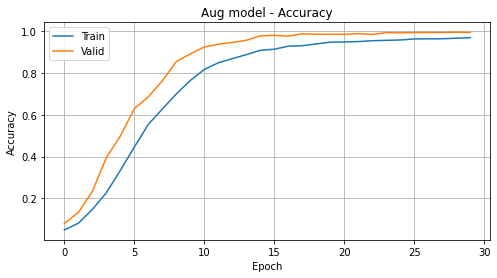

In [61]:
plot_curves(f'Aug model - Accuracy', [aug_model_1.history['acc_train'], aug_model_1.history['acc_valid']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


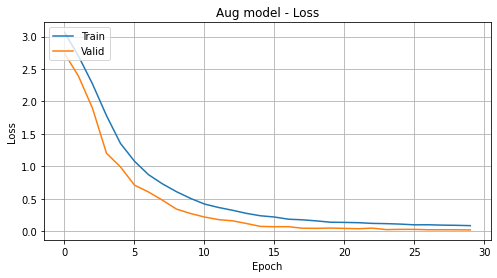

In [62]:
plot_curves(f'Aug model - Loss', [aug_model_1.history['loss_train'], aug_model_1.history['loss_valid']], 'Loss', 'Epoch', ['Train', 'Valid'])


# Transfer Learning

In [0]:
import tensorflow.keras as keras
from PIL import Image

In [0]:
def to_vgg16(data):
    rgb_data = np.repeat(data, 3, 3)
    padded_data = np.pad(rgb_data, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    return padded_data

In [0]:
train_x_32 = to_vgg16(train_x)
valid_x_32 = to_vgg16(valid_x)
test_x_32 = to_vgg16(test_x)

o_data_gen_3 = ImageDataGenerator(rescale=1.0/255.0,)

o_train_gen_3 = o_data_gen_3.flow(x=train_x_32, y=train_y, batch_size=BATCH_SIZE, shuffle=True)
o_valid_gen_3 = o_data_gen_3.flow(x=valid_x_32, y=valid_y, batch_size=VALID_BATCH_SIZE, shuffle=True)
o_test_gen_3 = o_data_gen_3.flow(x=test_x_32, y=test_y, batch_size=VALID_BATCH_SIZE, shuffle=True)

aug_data_gen_3 = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

aug_train_gen_3 = aug_data_gen_3.flow(x=train_x_32, y=train_y, batch_size=BATCH_SIZE, shuffle=True)

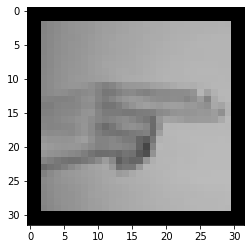

In [66]:
plt.imshow(o_train_gen_3.next()[0][0])

In [0]:
def get_vgg16_model():
    vgg16 = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    vgg16.trainable = True
    trainable = False
    for layer in vgg16.layers:
        if layer.name == 'block5_conv1':
            trainable = True
        layer.trainable = trainable

    model = keras.Sequential()

    model.add(vgg16)
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(OUTPUT, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=1e-5), 
                  metrics=['accuracy'])
    return model

In [68]:
tr_l_model = get_vgg16_model()

58892288/58889256 [==============================] - 397s 7us/step


In [69]:
tr_l_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3

In [90]:
tr_l_model.fit_generator(
    o_train_gen_3,
    steps_per_epoch=len(o_train_gen_3),
    epochs=TR_LAERN_EPOCH,
    validation_data=o_valid_gen_3,
    validation_steps=len(o_valid_gen_3)
)

Epoch 1/20
364/364 [==============================] - 7s 18ms/step - loss: 0.3756 - acc: 0.8836 - val_loss: 0.0345 - val_acc: 0.9957
Epoch 2/20
364/364 [==============================] - 7s 18ms/step - loss: 0.3457 - acc: 0.8949 - val_loss: 0.0277 - val_acc: 0.9960
Epoch 3/20
364/364 [==============================] - 7s 18ms/step - loss: 0.3169 - acc: 0.9039 - val_loss: 0.0212 - val_acc: 0.9977
Epoch 4/20
364/364 [==============================] - 7s 18ms/step - loss: 0.2861 - acc: 0.9128 - val_loss: 0.0176 - val_acc: 0.9985
Epoch 5/20
364/364 [==============================] - 7s 18ms/step - loss: 0.2652 - acc: 0.9204 - val_loss: 0.0120 - val_acc: 0.9987
Epoch 6/20
364/364 [==============================] - 7s 18ms/step - loss: 0.2487 - acc: 0.9220 - val_loss: 0.0111 - val_acc: 0.9985
Epoch 7/20
364/364 [==============================] - 7s 18ms/step - loss: 0.2233 - acc: 0.9328 - val_loss: 0.0096 - val_acc: 0.9990
Epoch 8/20
364/364 [==============================] - 7s 18ms/step - 

In [91]:
tr_l_loss, tr_l_acc = tr_l_model.evaluate_generator(o_test_gen_3, steps=len(o_test_gen_3))
tr_l_loss, tr_l_acc

(0.024298335984967386, 0.9937256)

In [72]:
print(f'Transfer Learning vgg16: loss - {tr_l_loss:.4f}\t Acc - {tr_l_acc:.02%}')

Transfer Learning vgg16: loss - 0.1247	 Acc - 96.39%


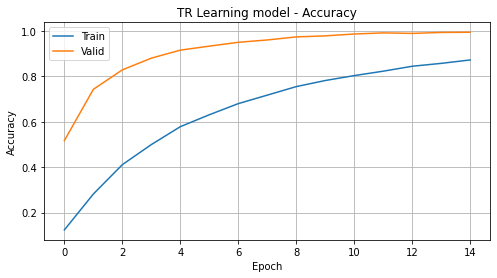

In [73]:
plot_curves(f'TR Learning model - Accuracy', [tr_l_model.history.history['acc'], tr_l_model.history.history['val_acc']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


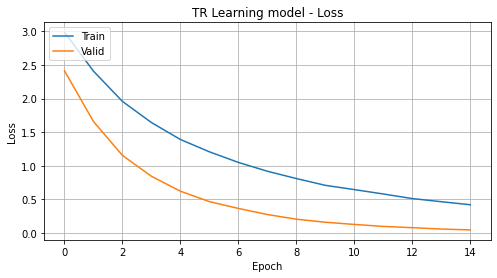

In [74]:
plot_curves(f'TR Learning model - Loss', [tr_l_model.history.history['loss'], tr_l_model.history.history['val_loss']], 'Loss', 'Epoch', ['Train', 'Valid'])


In [83]:
tr_l_model_aug = get_vgg16_model()
tr_l_model_aug.fit_generator(
    aug_train_gen_3,
    steps_per_epoch=len(aug_train_gen_3),
    epochs=TR_LAERN_EPOCH,
    validation_data=o_valid_gen_3,
    validation_steps=len(o_valid_gen_3)
)

tr_l_loss_aug, tr_l_acc_aug = tr_l_model_aug.evaluate_generator(o_test_gen_3, steps=len(o_test_gen_3))
tr_l_loss_aug, tr_l_acc_aug

Epoch 1/20
364/364 [==============================] - 14s 39ms/step - loss: 3.1842 - acc: 0.0604 - val_loss: 3.0676 - val_acc: 0.1625
Epoch 2/20
364/364 [==============================] - 14s 37ms/step - loss: 2.9900 - acc: 0.1180 - val_loss: 2.7723 - val_acc: 0.2865
Epoch 3/20
364/364 [==============================] - 13s 36ms/step - loss: 2.7895 - acc: 0.1701 - val_loss: 2.4425 - val_acc: 0.4021
Epoch 4/20
364/364 [==============================] - 13s 36ms/step - loss: 2.6098 - acc: 0.2195 - val_loss: 2.1468 - val_acc: 0.5152
Epoch 5/20
364/364 [==============================] - 13s 36ms/step - loss: 2.4527 - acc: 0.2709 - val_loss: 1.8835 - val_acc: 0.5276
Epoch 6/20
364/364 [==============================] - 13s 36ms/step - loss: 2.3072 - acc: 0.3019 - val_loss: 1.7281 - val_acc: 0.5630
Epoch 7/20
364/364 [==============================] - 13s 36ms/step - loss: 2.1878 - acc: 0.3384 - val_loss: 1.5564 - val_acc: 0.5994
Epoch 8/20
364/364 [==============================] - 13s 36ms

(0.8956145834078831, 0.7007808)

In [84]:
print(f'Transfer Learning vgg16: loss - {tr_l_loss_aug:.4f}\t Acc - {tr_l_acc_aug:.02%}')

Transfer Learning vgg16: loss - 0.8956	 Acc - 70.08%


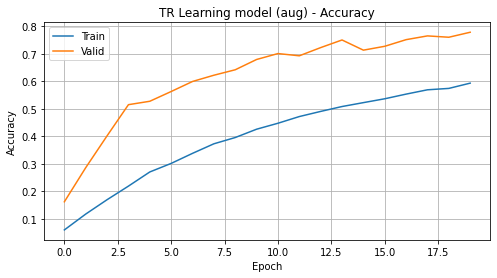

In [85]:
plot_curves(f'TR Learning model (aug) - Accuracy', [tr_l_model_aug.history.history['acc'], tr_l_model_aug.history.history['val_acc']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


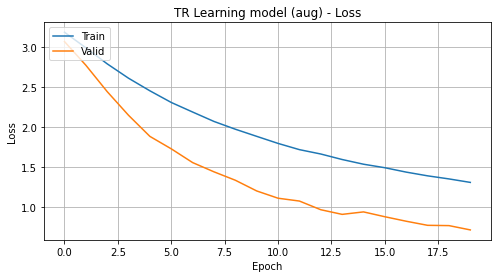

In [86]:
plot_curves(f'TR Learning model (aug) - Loss', [tr_l_model_aug.history.history['loss'], tr_l_model_aug.history.history['val_loss']], 'Loss', 'Epoch', ['Train', 'Valid'])


In [0]:
_, aug_test_acc = aug_model_1.evaluate_gen(o_test_gen)

In [0]:
_, orig_test_acc = orig_model_1.evaluate_gen(o_test_gen)

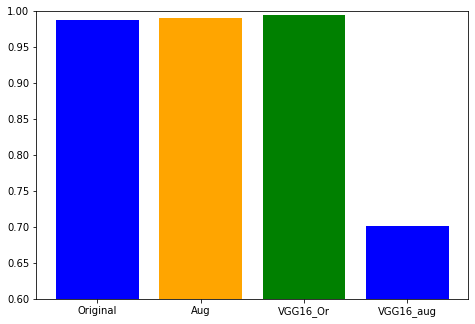

In [94]:
labels = ['Original', 'Aug', 'VGG16_Or', 'VGG16_aug']
test_acc = [orig_test_acc, aug_test_acc, tr_l_acc, tr_l_acc_aug]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,test_acc, color=['Blue', 'Orange', 'Green'])
plt.ylim(0.6,1)
plt.show()